In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm.notebook import tqdm
from glob import glob

%matplotlib inline

In [2]:
train = np.array([[i.split("-")[0].split("\\")[-1],i] for i in glob("images\\train\\*")])

In [3]:
y,x = train[:,0],train[:,1]

In [4]:
x = np.array([cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB) for i in list(x)])

In [5]:
x = (x / 255).astype(np.float32)

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint

### Base Network

<!-- |layer  | size-in    | size-out   | kernel     | param | FLPS |
|-------|------------|------------|------------|-------|------|
|conv1  | 220×220×3  | 110×110×64 | 7×7×3, 2   | 9K    |115M  |
|pool1  | 110×110×64 | 55×55×64   | 3×3×64, 2  | 0     |      |
|rnorm1 | 55×55×64   | 55×55×64   | 0          |       |      |
|conv2a | 55×55×64   | 55×55×64   | 1×1×64, 1  | 4K    | 13M  |
|conv2  | 55×55×64   | 55×55×192  | 3×3×64, 1  | 111K  | 335M |
|rnorm2 | 55×55×192  | 55×55×192  | 0          |       |      |
|pool2  | 55×55×192  | 28×28×192  | 3×3×192, 2 | 0     |      |
|conv3a | 28×28×192  | 28×28×192  | 1×1×192, 1 | 37K   | 29M  |
|conv3  | 28×28×192  | 28×28×384  | 3×3×192, 1 | 664K  | 521M |
|pool3  | 28×28×384  | 14×14×384  | 3×3×384, 2 | 0     |      |
|conv4a | 14×14×384  | 14×14×384  | 1×1×384, 1 | 148K  | 29M  |
|conv4  | 14×14×384  | 14×14×256  | 3×3×384, 1 | 885K  | 173M |
|conv5a | 14×14×256  | 14×14×256  | 1×1×256, 1 | 66K   | 13M  |
|conv5  | 14×14×256  | 14×14×256  | 3×3×256, 1 | 590K  | 116M |
|conv6a | 14×14×256  | 14×14×256  | 1×1×256, 1 | 66K   | 13M  |
|conv6  | 14×14×256  | 14×14×256  | 3×3×256, 1 | 590K  | 116M |
|pool4  | 14×14×256  | 7×7×256    | 3×3×256, 2 | 0     |      |
|concat | 7×7×256    | 7×7×256    | 0          |       |      |
|fc1    | 7×7×256    | 1×32×128   | maxout p=2 | 103M  | 103M |
|fc2    | 1×32×128   | 1×32×128   | maxout p=2 | 34M   | 34M  |
|fc7128 | 1×32×128   | 1×1×128    | 524K 0.5M  |       |      |
|L2     | 1×1×128    | 1×1×128    | 0          |       |      | -->

In [7]:
d = 128

In [8]:
def base_network(d=d):

    _input = Input(shape=(110,110,3))

    a_conv0 = Conv2D(32,3,activation="relu",padding="same")(_input)
    a_conv1 = Conv2D(32,3,activation="relu",padding="same")(a_conv0)
    a_conv2 = Conv2D(32,3,activation="relu",padding="same")(a_conv1)
    a_conc = concatenate([a_conv0,a_conv2,a_conv2])
    a_pool = MaxPool2D()(a_conc)

    b_conv0 = Conv2D(32,3,activation="relu",padding="same")(a_pool)
    b_conv1 = Conv2D(32,3,activation="relu",padding="same")(b_conv0)
    b_conv2 = Conv2D(32,3,activation="relu",padding="same")(b_conv1)
    b_conc = concatenate([a_pool,b_conv0,b_conv2,b_conv2])
    b_pool = MaxPool2D()(b_conc)

    c_conv0 = Conv2D(64,3,activation="relu",padding="same")(b_pool)
    c_conv1 = Conv2D(64,3,activation="relu",padding="same")(c_conv0)
    c_conv2 = Conv2D(64,3,activation="relu",padding="same")(c_conv1)
    c_conc = concatenate([b_pool,c_conv0,c_conv2,c_conv2])
    c_pool = MaxPool2D()(c_conc)

    d_conv0 = Conv2D(64,3,activation="relu",padding="same")(c_pool)
    d_conv1 = Conv2D(64,3,activation="relu",padding="same")(d_conv0)
    d_conv2 = Conv2D(64,3,activation="relu",padding="same")(d_conv1)
    d_conc = concatenate([c_pool,d_conv0,d_conv2,d_conv2])
    d_pool = MaxPool2D()(d_conc)

    e_conv0 = Conv2D(128,3,activation="relu",padding="same")(d_pool)
    e_conv1 = Conv2D(128,3,activation="relu",padding="same")(e_conv0)
    e_conv2 = Conv2D(128,3,activation="relu",padding="same")(e_conv1)
    e_conv3 = Conv2D(128,3,activation="relu",padding="same")(e_conv2)
    e_conc = concatenate([d_pool,e_conv0,e_conv1,e_conv2,e_conv3])
    e_pool = MaxPool2D()(e_conc)

    f_conv0 = Conv2D(256,3,activation="relu",padding="same")(e_pool)
    f_conv1 = Conv2D(256,3,activation="relu",padding="same")(f_conv0)
    f_conv2 = Conv2D(256,3,activation="relu",padding="same")(f_conv1)
    f_conv3 = Conv2D(256,3,activation="relu",padding="same")(f_conv2)
    f_conc = concatenate([f_conv0,f_conv1,f_conv2,f_conv3])
    f_pool = MaxPool2D()(f_conc)

    dense = Flatten()(f_pool)
    dense = Dense(512,activation="linear")(dense)
    dense = Dense(d,activation="tanh")(dense)

    dense = tf.multiply(dense,128)
    
    model = keras.Model(_input,dense)
    return model

### Pairs

In [9]:
class Pairs(object):
    def __init__(self,x,y,model=None):
        assert len(x) == len(y)
        self.x = x.reshape(-1,*x[0].shape[:2],3)
        self.y = y
        self.model = model
        self.dummy = np.array([[0]])
        
    def get_pair(self,e,x,y):
        a = x.reshape(1,110,110,3)
        
        p_index = np.where(self.y == y)
        n_index = np.where(self.y != y)

        p = self.epoch_enc[p_index]
        n = self.epoch_enc[n_index]

        p_dist = np.sum(np.square(p - e),axis=1).argmax()
        n_dist = np.sum(np.square(n - e),axis=1).argmin()

        p = self.x[p_index][p_dist].reshape(1,110,110,3)
        n = self.x[n_index][n_dist].reshape(1,110,110,3)
        
        return np.array([a,p,n])
        
    def flow(self,epochs=1):
        for epoch in range(epochs):
            self.epoch_enc = self.model.predict(self.x,batch_size=600)
            _iter = tqdm(zip(self.epoch_enc,self.x,self.y),total=len(self.epoch_enc))
            this_batch = np.array([self.get_pair(e,x,y) for e,x,y in _iter])
            for a,p,n in this_batch:
                yield (a,p,n),self.dummy

In [10]:
model = base_network()
pairs = Pairs(x,y,model=model)
flow = pairs.flow(epochs=1)

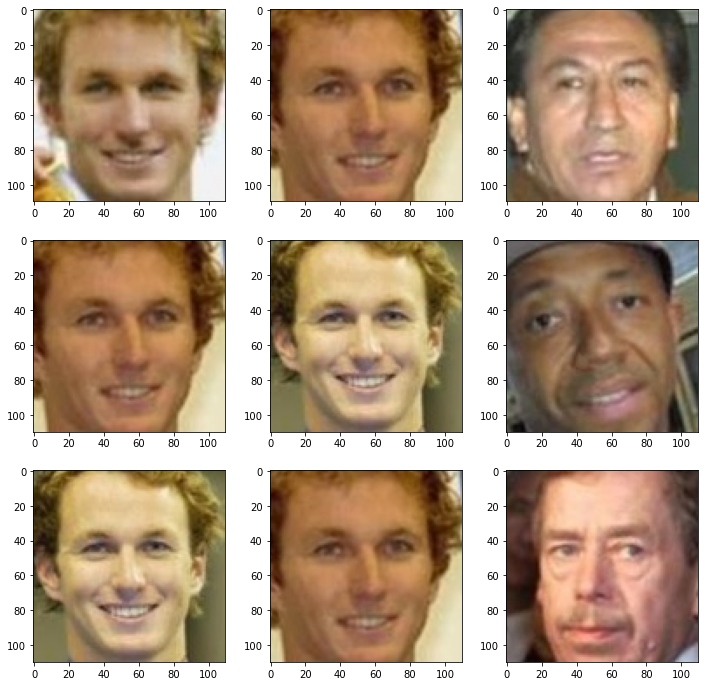

In [11]:
fig,axes = plt.subplots(3,3,figsize=(12,12))

for ax in axes:
    (a,p,n),r = next(flow)
    ax[0].imshow(a.reshape(110,110,3))
    ax[1].imshow(p.reshape(110,110,3))
    ax[2].imshow(n.reshape(110,110,3))

### Triplet Loss

### Triplet 

![](triplet.png)

In [12]:
class Triplet(tf.Module):
    """
    Triplet Loss
    """
    def __init__(self,margin=.75):
        self.margin = margin
        
    @tf.function
    def l2(self,x,y):
        return tf.reduce_sum(tf.square(tf.subtract(x,y)))
    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        a,p,n = tf.unstack(tf.reshape(y_pred,(3,-1,d)))
        
        Dp = self.l2(a,p)
        Dn = self.l2(a,n)
        
        return tf.nn.relu(Dp - Dn + self.margin)

In [13]:
model = base_network()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 110, 110, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 110, 110, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 110, 110, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 110, 110, 32) 9248        conv2d_21[0][0]                  
____________________________________________________________________________________________

In [14]:
a_inp = Input(shape=(110,110,3),name="anc")
p_inp = Input(shape=(110,110,3),name="pos")
n_inp = Input(shape=(110,110,3),name="neg")

a_net = model(a_inp)
p_net = model(p_inp)
n_net = model(n_inp)

out = concatenate([a_net,p_net,n_net],name="out")
train = keras.Model([a_inp,p_inp,n_inp],out)

In [15]:
triplet = Triplet(margin=1.0)

In [16]:
def schedule(epoch):
    if epoch > 5:
        return .00001
    else:
        return .0001

In [17]:
lrs = LearningRateScheduler(schedule)
ckp = ModelCheckpoint(filepath="./checkpoints/facenet",save_weights_only=True)

In [18]:
opt = keras.optimizers.Adagrad(0.0001)

In [19]:
train.compile(optimizer=opt,loss=triplet)

In [20]:
epochs = 15

In [21]:
pairs = Pairs(x,y,model=model)
flow = pairs.flow(epochs=epochs)

In [22]:
history = train.fit_generator(flow,steps_per_epoch=len(x),epochs=epochs,callbacks=[ckp])

Instructions for updating:
Please use Model.fit, which supports generators.



  ...
    to  
  ['...']
Train for 150 steps
Epoch 1/15
142/150 [===========================>..] - ETA: 1s - loss: 63.7854

150/150 [==============================] - 23s 151ms/step - loss: 62.8651
Epoch 2/15

142/150 [===========================>..] - ETA: 0s - loss: 33.8470

150/150 [==============================] - 19s 126ms/step - loss: 33.8757
Epoch 3/15

142/150 [===========================>..] - ETA: 0s - loss: 18.6128

150/150 [==============================] - 18s 118ms/step - loss: 19.0548
Epoch 4/15

142/150 [===========================>..] - ETA: 0s - loss: 10.9651

150/150 [==============================] - 18s 120ms/step - loss: 11.1259
Epoch 5/15

142/150 [===========================>..] - ETA: 0s - loss: 5.9801

150/150 [==============================] - 19s 124ms/step - loss: 6.1243
Epoch 6/15

142/150 [===========================>..] - ETA: 0s - loss: 4.2265

150/150 [==============================] - 18s 118ms/step - loss: 4.2280
Epoch 7/15

142/150 [===========================>..] - ETA: 0s - loss: 1.8956

150/150 [==============================] - 18s 117ms/step - loss: 1.8532
Epoch 8/15

142/150 [===========================>..] - ETA: 0s - loss: 0.8154

150/150 [==============================] - 18s 118ms/step - loss: 0.9136
Epoch 9/15

142/150 [===========================>..] - ETA: 0s - loss: 0.6149

150/150 [==============================] - 17s 114ms/step - loss: 0.6177
Epoch 10/15

142/150 [===========================>..] - ETA: 0s - loss: 0.3054

150/150 [==============================] - 17s 117ms/step - loss: 0.3084
Epoch 11/15

142/150 [===========================>..] - ETA: 0s - loss: 0.0923

150/150 [==============================] - 17s 113ms/step - loss: 0.1179
Epoch 12/15

142/150 [===========================>..] - ETA: 0s - loss: 0.0336

150/150 [==============================] - 17s 115ms/step - loss: 0.0319
Epoch 13/15

142/150 [===========================>..] - ETA: 0s - loss: 0.0000e+00

150/150 [==============================] - 18s 117ms/step - loss: 0.0000e+00
Epoch 14/15

142/150 [===========================>..] - ETA: 0s - loss: 0.0000e+00

150/150 [==============================] - 18s 117ms/step - loss: 0.0000e+00
Epoch 15/15

150/150 [==============================] - 17s 115ms/step - loss: 0.0000e+00


In [28]:
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as ex

In [90]:
p = model.predict(x,batch_size=5)

In [91]:
tsne = TSNE(2,)

In [92]:
a = tsne.fit_transform(p)

Text(0.5, 1.0, '2 Dimentional Clustering')

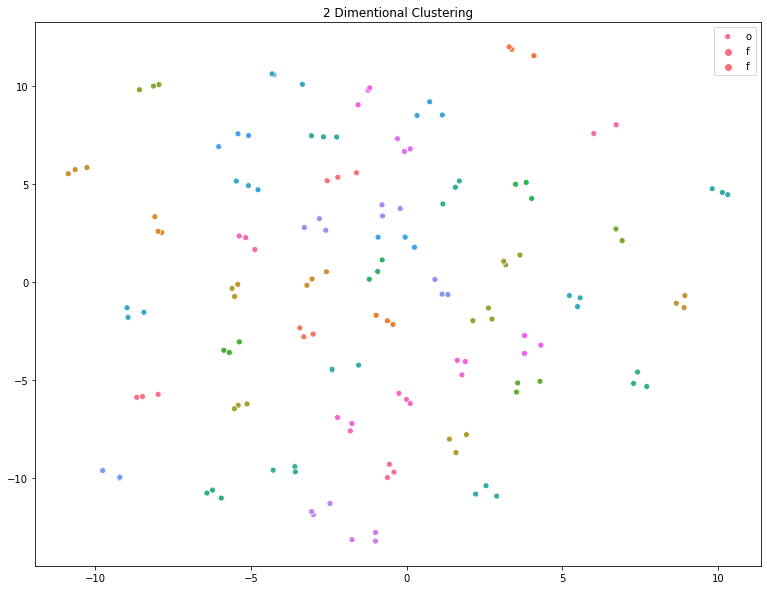

In [93]:
fig = plt.figure(figsize=(13,10))
sns.scatterplot(a[:,0],a[:,1],hue=y)
plt.legend("off")
plt.title("2 Dimentional Clustering")

In [94]:
fig.savefig("../doc/2d_cluster.jpg")

In [78]:
tsne = TSNE(3,)

In [79]:
a = tsne.fit_transform(p)

In [81]:
ex.scatter_3d(x=a[:,0],y=a[:,1],z = a[:,2],color=y)